[Group 1 Galaxies](#1)
[Group 2 Galaxies](#2)
[Group 3 Galaxies](#3)
[Group 4 Galaxies](#4)
[Group 5 Galaxies](#5)
[Group 6 Galaxies](#6)

### This code provides most of the figures for Vivi's presentation at CfA

### Galaxy morphology by groups: Groups 1 (perfectly disks), 2, 3, 4, 5 and 6 (ellipticals)

In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor


In [2]:
import target_predicting_ML_functions_and_feature_ranking as functions

In [3]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel("R2 score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here


In [132]:
# df here read from the data filtered file from notebook v5, the original dataset before normalization and pruning
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

#### Read the normalized 31-feature dataset (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [4]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

#### Add the column 'BulgeMstar_ratio' defined as Bulge mass / Stellar mass, to be used as a proxy for galaxy morphology

In [5]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']


#### Define the 6 morphology groups by increasing Mbulge/Mstar ratio

In [8]:
# 7,865 galaxies in df_1
df_1 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.10] 

# 13,921 galaxies in df_2
df_2 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.10) & (df_normalized_31.BulgeMstar_ratio <= 0.20)] 

# 6,880 galaxies in df_3
df_3 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.20) & (df_normalized_31.BulgeMstar_ratio <= 0.30)] 

# 2,858 galaxies in df_4
df_4 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.30) & (df_normalized_31.BulgeMstar_ratio <= 0.40)] 

# 1,444 galaxies in df_5
df_5 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.40) & (df_normalized_31.BulgeMstar_ratio <= 0.50)] 

# 2,422 galaxies in df_5
df_6 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']>0.50] 

In [75]:
# this code takes ~ 50min to run it on the complete dataset with ~35,000 galaxies 
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[1000], \
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Complete Dataset: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.953, test=0.915) total time= 8.5min
[CV 3/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.952, test=0.912) total time= 8.7min
[CV 1/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.958, test=0.921) total time= 9.1min
Best params, best score: 0.9162 {'svr__C': 1000, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Complete Dataset: 2832.227 seconds


In [76]:
best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [77]:
y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

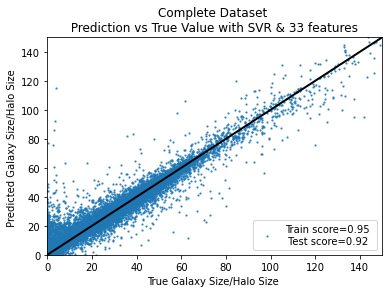

In [81]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_all, y_pred_SVR_all, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Complete Dataset \n Prediction vs True Value with SVR & 33 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Complete_Dataset_Prediction_vs_True_SVR_33feat.jpeg', dpi=500)

plt.show()

Elapsed time to run SVR Learning Curves on the complete dataset: 2714.244 seconds


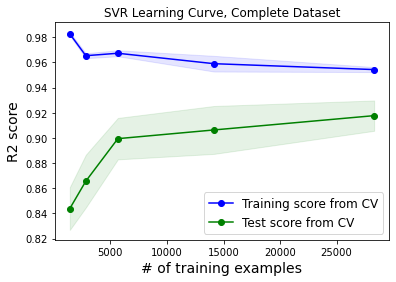

In [84]:
# this code takes ~2.5min to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR Learning Curve, Complete Dataset', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

In [82]:
# lc_all.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)

<Figure size 432x288 with 0 Axes>

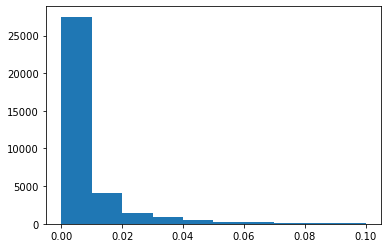

In [127]:
plt.hist(df_normalized_31.loc[:, 'GalpropNormMstar'], range=(0,0.1))
plt.show()

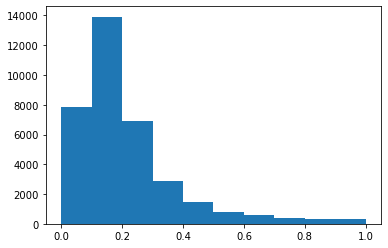

In [48]:
plt.hist(df_normalized_31.loc[:, 'BulgeMstar_ratio'])
plt.show()


## <font color='purple'> <a id =1> </a> <br> Mass vs Size and Spin vs Size plots (Normalized Mass, Normalized Spin)

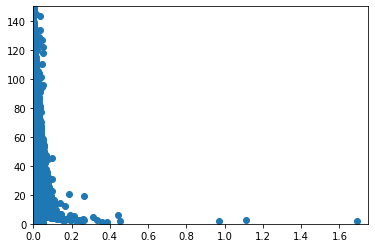

In [130]:
plt.scatter(df_normalized_31.loc[:, 'GalpropNormMstar'], df_normalized_31.loc[:, 'GalpropNormHalfRadius'])
plt.xlim(0,1.75)
plt.ylim(0,150)
plt.show()



In [16]:
mass_size_corr = round(stats.spearmanr(df_normalized_31.loc[:, 'GalpropNormMstar'], df_normalized_31.loc[:, 'GalpropNormHalfRadius'])[0], 2)
spin_size_corr = round(stats.spearmanr(df_normalized_31.loc[:, 'HalopropSpin'], df_normalized_31.loc[:, 'GalpropNormHalfRadius'])[0], 2)



print(mass_size_corr, spin_size_corr)

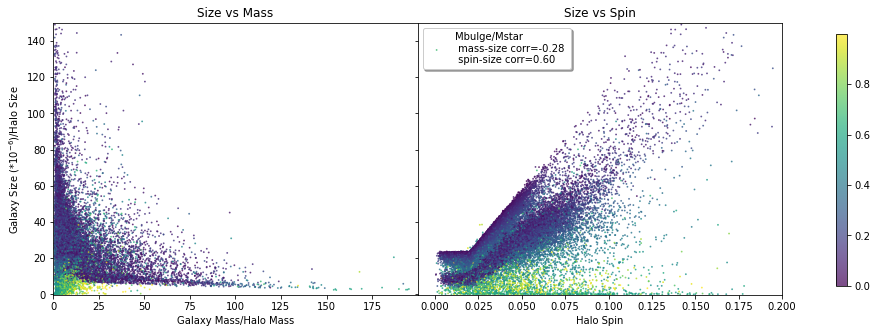

In [131]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
# fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = ('Mbulge/Mstar \n mass-size corr=-0.28 \n spin-size corr=0.60')
im1 = ax1.scatter(df_normalized_31.loc[:, 'GalpropNormMstar']*1000, df_normalized_31.loc[:, 'GalpropNormHalfRadius'], 
                  c = (df_normalized_31.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7) #, label=label) # , vmin=-2, vmax=1.0)

ax1.set_xlim([0, 200])
ax1.set_xticks([0.0, 25, 50, 75, 100, 125, 150, 175])
ax1.set_ylim([-0.2,150])
ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Galaxy Size (*$10^{-6}$)/Halo Size ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized_31.loc[:, 'HalopropSpin'], df_normalized_31.loc[:, 'GalpropNormHalfRadius'], 
                    c = (df_normalized_31.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, label=label) #,  vmin=0.2, vmax=1.0)#, label=label)

     
ax2.set_xlim([-0.01,0.20])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_NormalizedMass_NormalizedSize_Spin_no_title.jpeg", dpi=500)
plt.show()

#### Raw dataset (not normalized) plots

In [143]:
mass_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5.loc[:, 'GalpropMstar'], df_log_mass_filtered_v5.loc[:, 'GalpropHalfRadius'])[0], 2)
spin_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5.loc[:, 'HalopropSpin'], df_log_mass_filtered_v5.loc[:, 'GalpropHalfRadius'])[0], 2)



print(mass_size_corr, spin_size_corr)

0.27 0.62


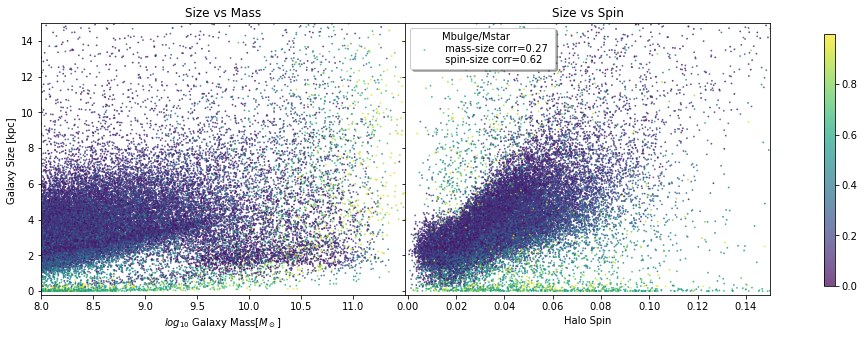

In [171]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
# fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = ('Mbulge/Mstar \n mass-size corr=0.27 \n spin-size corr=0.62')
im1 = ax1.scatter(np.log10(df_log_mass_filtered_v5.loc[:, 'GalpropMstar']),
                  df_log_mass_filtered_v5.loc[:, 'GalpropHalfRadius'], 
                  c = (df_log_mass_filtered_v5.loc[:, 'GalpropMbulge']/df_log_mass_filtered_v5.loc[:, 'GalpropMstar']), 
                  s=3, marker='.', alpha=0.7) #, label=label) # , vmin=-2, vmax=1.0)

ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-0.2,15])
ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('$log_{10}$ Galaxy Mass$[M_\odot]$ ')
ax1.set_ylabel('Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_log_mass_filtered_v5.loc[:, 'HalopropSpin'],
                  df_log_mass_filtered_v5.loc[:, 'GalpropHalfRadius'], 
                  c = (df_log_mass_filtered_v5.loc[:, 'GalpropMbulge']/df_log_mass_filtered_v5.loc[:, 'GalpropMstar']), 
                  s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)
     
ax2.set_xlim([-0.001,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='best' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_RawMass_RawSize_Spin_no_title.jpeg", dpi=500)
plt.show()

## <font color='purple'> <a id =2> </a> <br> Correlations Matrix

In [64]:
df_sample = df_normalized_31.sample(n = 1000, random_state = 2022)

In [72]:
df_sample.drop(columns=['BulgeMstar_ratio'])

,GalpropMaccdot_radio,GalpropMu_merger,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropTmerger,GalpropTmerger_major,...,GalpropNormMBH,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,HalopropNormMass_ejected,HalopropNormMstar_diffuse,GalpropNormSigmaBulge,GalpropNormVdisk
18973,2.546640e-08,0.000000,0.767773,0.027392,0.007492,0.007073,0.008232,0.004599,113.70200,113.70200,...,0.000003,0.000195,0.004878,0.003800,0.011948,0.000070,0.155195,0.000019,0.699350,0.993085
6214,3.828150e-06,0.198475,10.869300,2.194480,1.522320,1.401830,1.455530,0.933354,3.81310,8.55232,...,0.000003,0.002426,0.006538,0.002959,0.016113,0.001531,0.098519,0.000391,0.894638,1.105247
15802,1.009640e-07,0.369379,2.063460,0.123078,0.085103,0.079055,0.085414,0.052200,1.81361,1.81361,...,0.000002,0.000842,0.013519,0.007759,0.029836,0.000749,0.134690,0.000188,1.779834,1.186156
14031,4.845980e-08,0.245413,2.101240,0.099465,0.064973,0.062168,0.044866,0.039910,8.62931,11.48680,...,0.000002,0.000905,0.012243,0.006415,0.026254,0.000217,0.151535,0.000055,0.801771,1.209455
29406,1.932890e-08,0.166016,0.991989,0.045256,0.013023,0.004130,0.003947,0.006479,7.28043,12.96870,...,0.000004,0.000854,0.005623,0.004667,0.014833,0.000319,0.345808,0.000094,2.248754,0.993083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471,5.077540e-08,0.246356,0.745250,0.087285,0.015061,0.014977,0.033772,0.009268,9.75500,12.20270,...,0.000002,0.000185,0.001617,0.001398,0.004282,0.000291,0.152596,0.000078,0.703662,0.993084
14226,1.327210e-08,0.255811,0.883911,0.024803,0.024390,0.022422,0.013574,0.014953,11.67610,11.67610,...,0.000002,0.000664,0.014608,0.007845,0.031162,0.000047,0.137578,0.000021,0.859343,1.403815
16715,5.143070e-08,0.105039,1.151720,0.062283,0.018017,0.020859,0.044860,0.011046,10.39340,11.01180,...,0.000002,0.000288,0.006597,0.005355,0.016432,0.000048,0.145686,0.000012,0.737961,0.993085
22512,3.145880e-07,0.254366,3.353810,0.674049,0.159563,0.148891,0.189999,0.097892,7.90487,7.90487,...,0.000009,0.000785,0.003608,0.002139,0.008812,0.000259,0.147054,0.000074,0.709799,0.993083


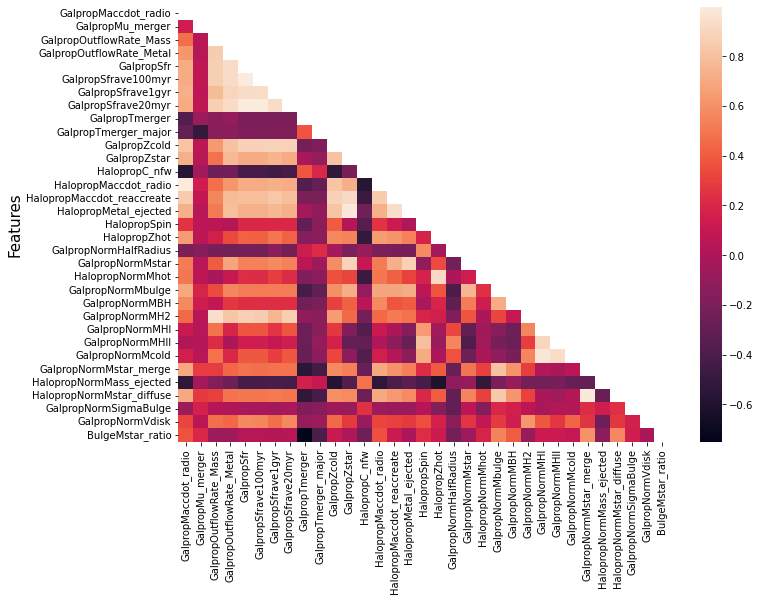

In [76]:
corr_df = df_sample.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, mask=matrix)
# plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
plt.ylabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix_df_normalized_31.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =3> </a> <br> LR, RF & SVR results - All morphologies (using the complete dataset)

### RF

In [78]:
X_all = df_normalized_31.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_all = df_normalized_31.loc[:,'GalpropNormHalfRadius']

In [80]:
regr_RF = RandomForestRegressor(random_state=0)

# number of trees in random forest
n_estimators = [100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Re-design the grid using the best params obtained from gridsearchCV on the complete dataset in notebook v19
# Best params, best score: 0.9144 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}

# Grid search of parameters
rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
    rfr_grid.best_params_)
# define trainscore according to best model
best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF = cross_val_predict(best_RF, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF = cross_val_score(best_RF, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params, best score: 0.9150 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
RF Accuracy: 0.92 (+/- 0.01)


Elapsed time to run SVR Learning Curves on the complete dataset: 93.915 seconds


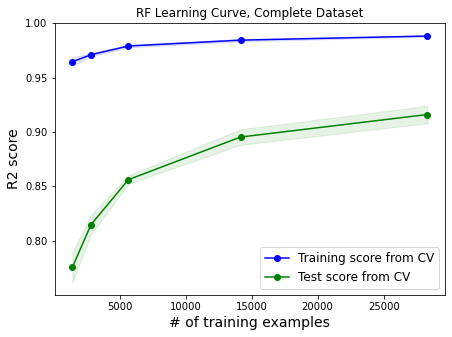

In [81]:
# this code takes ~2.5min to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all_rf = plot_learning_curve(best_RF, 'RF Learning Curve, Complete Dataset', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_RF_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

### LR

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

In [83]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.6147808623618454

In [84]:
reg.score(X_test, y_test)

0.5639747393394643

In [85]:
y_pred_LR = cross_val_predict(reg, X_test, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

Elapsed time to run SVR Learning Curves on the complete dataset: 0.733 seconds


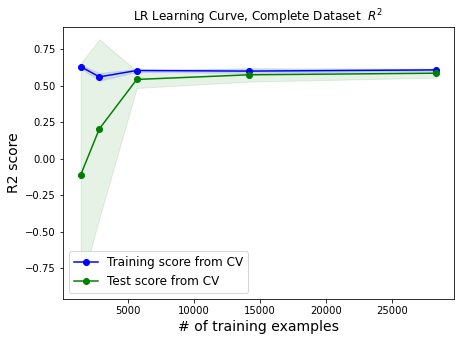

In [91]:
# this code takes ~2.5min to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all_lr = plot_learning_curve(reg, 'LR Learning Curve, Complete Dataset  $R^{2} $', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

### SVR

In [87]:
# this code takes ~ 1.2 hrs to run it on the complete dataset with ~35,000 galaxies 
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[1000], \
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Complete Dataset: {elapsed_time:.3f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.953, test=0.920) total time=25.9min
[CV 3/5] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.952, test=0.923) total time=27.4min
[CV 4/5] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.956, test=0.899) total time=27.5min
[CV 1/5] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.952, test=0.926) total time=27.7min
[CV 5/5] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.959, test=0.927) total time=30.9min
Best params, best score: 0.9191 {'svr__C': 1000, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Complete Dataset: 4166.486 seconds


In [89]:
best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [92]:
y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
# this code takes ~2.5min to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all_svr = plot_learning_curve(best_SVR_all, 'SVR Learning Curve, Complete Dataset', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

## <font color='purple'> <a id =4> </a> <br> LR, RF, SVR figure

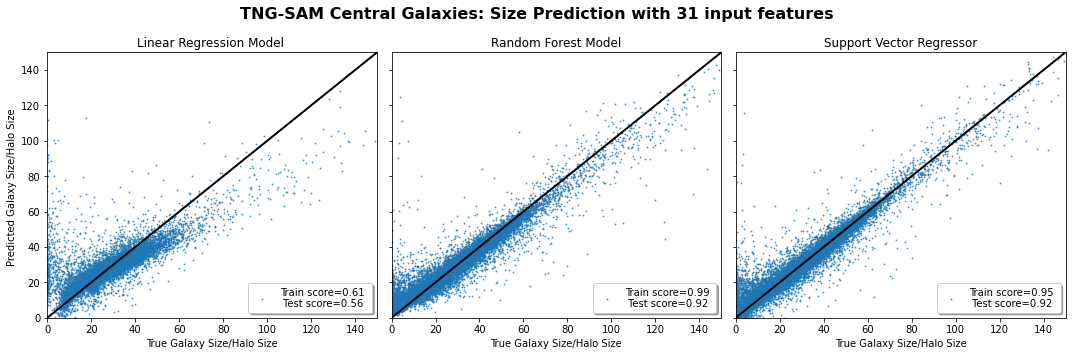

In [111]:
fig1,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
# fig1.suptitle('TNG-SAM Central Galaxies: Size Prediction with 31 input features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,150, 0.0,150])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y_all, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim(auto=True)
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim(auto=True)
ax5.axis([0.0,150, 0.0,150])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )
im6 = ax6.scatter(y_all, y_pred_SVR_all, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.0,150, 0.0,150])
ax6.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig1.tight_layout()
# fig1.savefig("TNG-SAM_LR_RF_SVR_size_prediction_31feat.jpeg", dpi=500)
plt.show()

In [119]:
df_normalized_31.shape

(35390, 33)

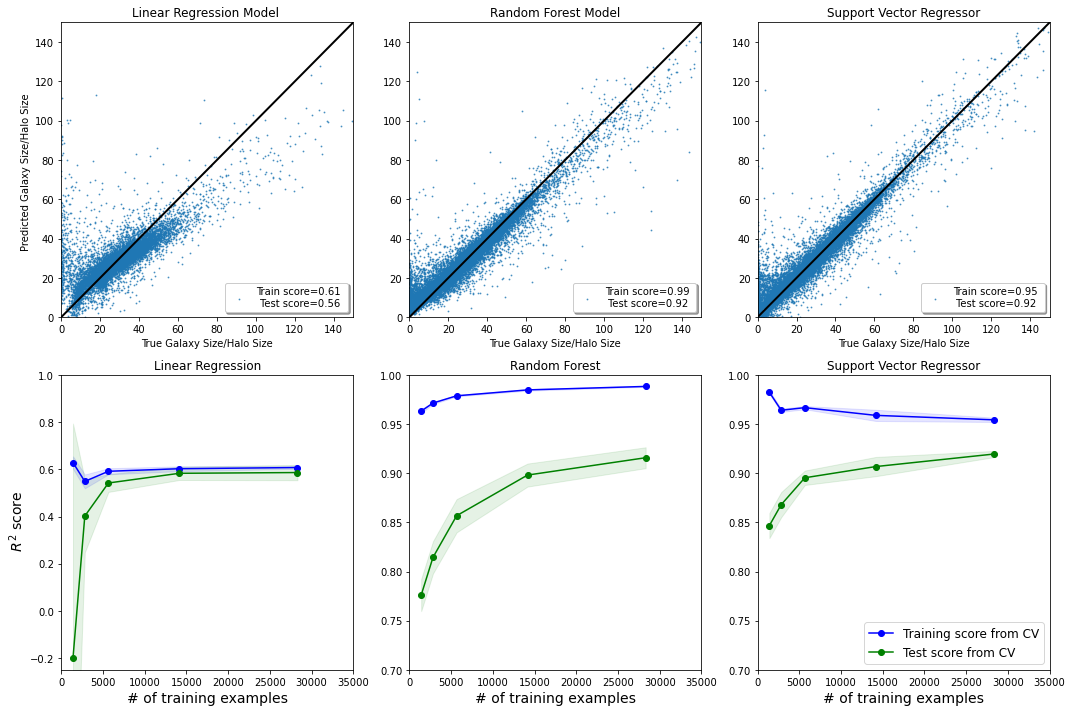

Elapsed time to plot prediction & learning curves fig: 6468.645 seconds


In [120]:
start_time = time.time()
fig,[(ax1, ax2, ax3), (ax4, ax5, ax6) ]=plt.subplots(nrows=2,ncols=3, figsize=(15,10))
# fig.suptitle('TNG-SAM Central Galaxies Size Prediction - 33 features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,150, 0.0,150])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im2 = ax2.scatter(y_all, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
# ax2.set_xlim([9.0, 11.5])
# ax2.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax2.set_ylim([0.2,1.2])
ax2.axis([0.0,150, 0.0,150])
ax2.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax2.set_title('Random Forest Model')
ax2.set_xlabel('True Galaxy Size/Halo Size')
# ax2.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax2.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )
im3 = ax3.scatter(y_all, y_pred_SVR_all, s=3, marker='.', alpha=0.7, label=label)
# ax3.set_xlim([9.0, 11.5])
# ax3.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax3.set_ylim([0.2,1.2])
ax3.axis([0.0,150, 0.0,150])
ax3.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax3.set_title('Support Vector Regressor')
ax3.set_xlabel('True Galaxy Size/Halo Size')
# ax3.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax3.legend(loc='lower right', shadow=True)

# Learning Curve All morphologies, LR
ax4.set_title('Linear Regression')
# ylim = None
# if ylim is not None:
#     ax4.set_ylim(*ylim)
ax4.axis([0.0,35000, -0.25,1.0])
ax4.set_xlabel("# of training examples",fontsize = 14)

ax4.set_ylabel(" $R^{2}$ score",fontsize = 14)

scale = False
# if (scale == True):
#     scaler = sklearn.preprocessing.StandardScaler()
#     X_all = scaler.fit_transform(X_all)
    
train_sizes, train_scores, test_scores = learning_curve(
    reg, X_all, y_all, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax4.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax4.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

# ax4.legend(loc="best",fontsize = 12)

# Learning Curve All morphologies, Random Forest
ax5.set_title('Random Forest')
# ylim = None
# if ylim is not None:
#     ax5.set_ylim(*ylim)
ax5.axis([0.0,35000, 0.7,1.0])
ax5.set_xlabel("# of training examples",fontsize = 14)

# ax5.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
# if (scale == True):
#     scaler = sklearn.preprocessing.StandardScaler()
#     X_all = scaler.fit_transform(X_all)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF, X_all, y_all, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax5.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax5.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax5.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax5.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

# ax5.legend(loc="best",fontsize = 12)

# Learning Curve All morphologies, SVR
ax6.set_title('Support Vector Regressor')
# ylim = None
# if ylim is not None:
# ax6.set_ylim(auto=True)
ax6.axis([0.0,35000, 0.7,1.0])
ax6.set_xlabel("# of training examples",fontsize = 14)

# ax6.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
# if (scale == True):
#     scaler = sklearn.preprocessing.StandardScaler()
#     X_all = scaler.fit_transform(X_all)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_all, X_all, y_all, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax6.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax6.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax6.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax6.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax6.legend(loc="lower right",fontsize = 12)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_LR_RF_SVR_size_prediction_33feat.jpeg", dpi=500)
plt.show()

elapsed_time = time.time() - start_time

print(f"Elapsed time to plot prediction & learning curves fig: {elapsed_time:.3f} seconds")

In [121]:
# fig.savefig("TNG-SAM_LR_RF_SVR_size_prediction_LearningCurves_31feat_no_title_2.jpeg", dpi=500)



## <font color='purple'> <a id =5> </a> <br>Group 5: 0.4< B/Mstar <=0.5


## <font color='purple'> <a id =6> </a> <br> Group 6 (Elliptical) Galaxies:  B/Mstar > 0.5

In [50]:
X_6 = df_6.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


y_6 = df_6.loc[:,'GalpropNormHalfRadius']

### SVR Predicted vs True Sizes - The figure with all the results of each morphology bin

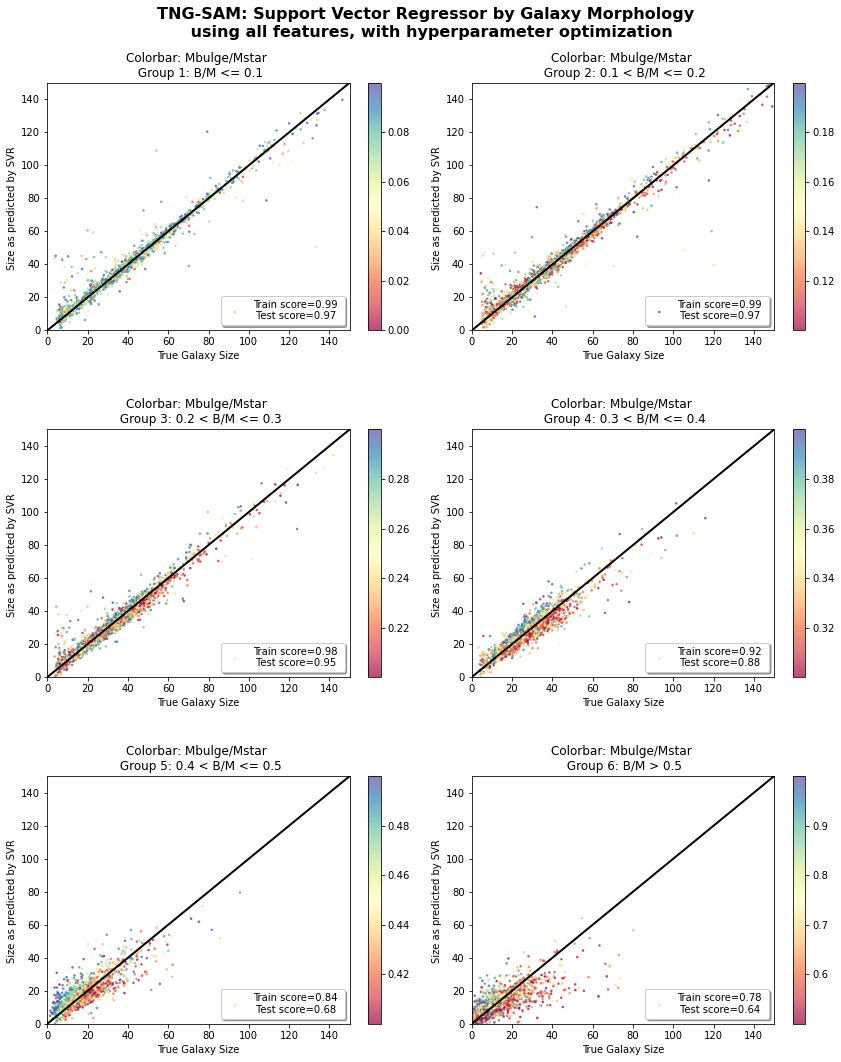

In [60]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Support Vector Regressor by Galaxy Morphology \n using all features, with hyperparameter optimization', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_1, 2),round(scores_SVR_1.mean(), 2) )
fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_1,
            c = df_1.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=label) #,label= label, vmin=-2, vmax=1.0)
# ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
# ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_1, ax=ax1)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_2, 2),round(scores_SVR_2.mean(), 2) )
fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_2,
            c = df_2.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
# ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
# ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_2, ax=ax2)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_3, 2),round(scores_SVR_3.mean(), 2) )
fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_3,
            c = df_3.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
# ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_3, ax=ax3)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_4, 2),round(scores_SVR_4.mean(), 2) )
fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_4,
            c = df_4.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
# ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_4, ax=ax4)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_5, 2),round(scores_SVR_5.mean(), 2) )
fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_5,
            c = df_5.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
# ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_5, ax=ax5)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_6, 2),round(scores_SVR_6.mean(), 2) )
fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_6,
            c = df_6.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Colorbar: Mbulge/Mstar \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_SVR_by_Galaxy_Morphology_w_hyperparam_opt_all_features.jpeg", dpi=500)
plt.show()

### SVR Learning Curves - The figure with all the results of each morphology bin

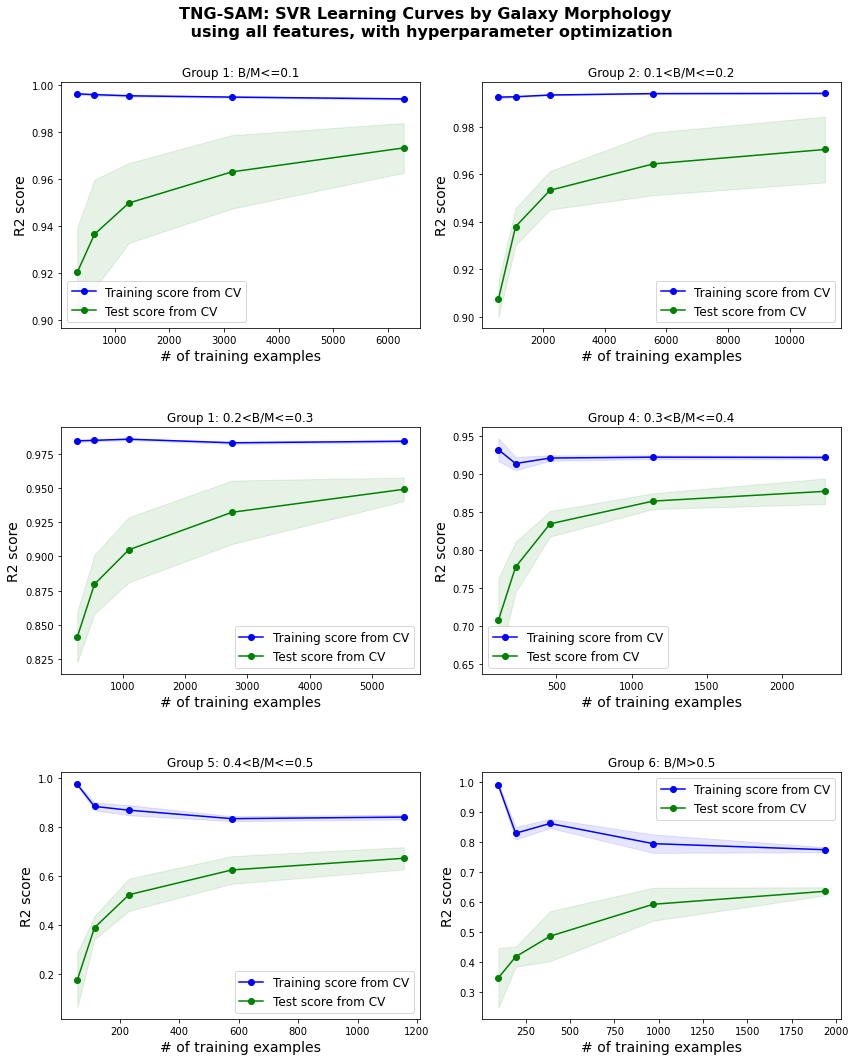

Elapsed time to plot SVR learning curves for all morphologies: 144.393 seconds


In [87]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import sklearn as sklearn

# def plot_learning_curve_for_6_galaxy_morphologies(estimator, title, X, y, ylim=None, cv=5,
#                         n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
#     """
#     Generate a simple plot of the test and training learning curve.

#     Parameters
#     ----------
#     estimator : object type that implements the "fit" and "predict" methods
#         An object of that type which is cloned for each validation.

#     title : string
#         Title for the chart.

#     X : array-like, shape (n_samples, n_features)
#         Training vector, where n_samples is the number of samples and
#         n_features is the number of features.

#     y : array-like, shape (n_samples) or (n_samples, n_features), optional
#         Target relative to X for classification or regression;
#         None for unsupervised learning.

#     ylim : tuple, shape (ymin, ymax), optional
#         Defines minimum and maximum yvalues plotted.

#     cv : int, cross-validation generator or an iterable, optional
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:
#           - None, to use the default 3-fold cross-validation,
#           - integer, to specify the number of folds.
#           - :term:`CV splitter`,
#           - An iterable yielding (train, test) splits as arrays of indices.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     n_jobs : int or None, optional (default=None)
#         Number of jobs to run in parallel.
#         ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
#         ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
#         for more details.

#     train_sizes : array-like, shape (n_ticks,), dtype float or int
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the dtype is float, it is regarded as a
#         fraction of the maximum size of the training set (that is determined
#         by the selected validation method), i.e. it has to be within (0, 1].
#         Otherwise it is interpreted as absolute sizes of the training sets.
#         Note that for classification the number of samples usually have to
#         be big enough to contain at least one sample from each class.
#         (default: np.linspace(0.1, 1.0, 5))
#     """

start_time = time.time()
lc_fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
lc_fig_all.suptitle('TNG-SAM: SVR Learning Curves by Galaxy Morphology \n using all features, with hyperparameter optimization', fontsize=16, fontweight='bold')

# Learning Curve Group 1
ax1.set_title('Group 1: B/M<=0.1')
ylim = None
if ylim is not None:
    ax1.set_ylim(*ylim)
ax1.set_xlabel("# of training examples",fontsize = 14)

ax1.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_1 = scaler.fit_transform(X_1)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_1, X_1, y_1, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax1.legend(loc="best",fontsize = 12)

# Learning Curve Group 2
ax2.set_title('Group 2: 0.1<B/M<=0.2')
ylim = None
if ylim is not None:
    ax2.set_ylim(*ylim)
ax2.set_xlabel("# of training examples",fontsize = 14)

ax2.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_2 = scaler.fit_transform(X_2)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_2, X_2, y_2, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax2.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax2.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax2.legend(loc="best",fontsize = 12)

# Learning Curve Group 3
ax3.set_title('Group 1: 0.2<B/M<=0.3')
ylim = None
if ylim is not None:
    ax3.set_ylim(*ylim)
ax3.set_xlabel("# of training examples",fontsize = 14)

ax3.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_3 = scaler.fit_transform(X_3)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_3, X_3, y_3, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax3.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax3.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax3.legend(loc="best",fontsize = 12)

# Learning Curve Group 4
ax4.set_title('Group 4: 0.3<B/M<=0.4')
ylim = None
if ylim is not None:
    ax4.set_ylim(*ylim)
ax4.set_xlabel("# of training examples",fontsize = 14)

ax4.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_4 = scaler.fit_transform(X_4)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_4, X_4, y_4, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax4.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax4.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax4.legend(loc="best",fontsize = 12)

# Learning Curve Group 5
ax5.set_title('Group 5: 0.4<B/M<=0.5')
ylim = None
if ylim is not None:
    ax5.set_ylim(*ylim)
ax5.set_xlabel("# of training examples",fontsize = 14)

ax5.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_5 = scaler.fit_transform(X_5)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_5, X_5, y_5, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax5.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax5.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax5.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax5.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax5.legend(loc="best",fontsize = 12)

# Learning Curve Group 6
ax6.set_title('Group 6: B/M>0.5')
ylim = None
if ylim is not None:
    ax6.set_ylim(*ylim)
ax6.set_xlabel("# of training examples",fontsize = 14)

ax6.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_6 = scaler.fit_transform(X_6)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_6, X_6, y_6, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax6.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax6.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax6.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax6.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax6.legend(loc="best",fontsize = 12)

lc_fig_all.tight_layout()
lc_fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

plt.savefig("TNG-SAM_LearningCurves_SVR_by_Galaxy_Morphology_w_hyperparam_opt_all_features.jpeg", dpi=500)
plt.show()
elapsed_time = time.time() - start_time
# print(f"Elapsed time to plot SVR learning curves for all morphologies: {elapsed_time:.3f} seconds")


## All morphologies feature ranking plot

In [152]:
df_max_r_scores=pd.read_csv('RFranking_allmorphologies_Max r scores by add column method.csv')

In [153]:
df_max_r_scores

,feature_number,features,r_sq_score
0,1,HalopropSpin,0.383211
1,2,GalpropNormMstar_merge,0.569557
2,3,GalpropNormMstar,0.705899
3,4,GalpropNormVdisk,0.809368
4,5,GalpropNormMbulge,0.915333
5,6,GalpropNormSigmaBulge,0.927868
6,7,HalopropNormMstar_diffuse,0.932271
7,8,GalpropMaccdot_radio,0.932349
8,9,HalopropMetal_ejected,0.932192
9,10,GalpropZstar,0.931228


Text(0, 0.5, '$R^{2}$ score')

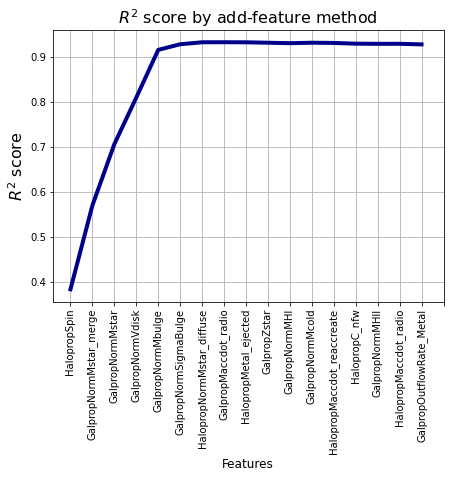

In [167]:
fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, lw=4, color = 'darkblue',
                    xticks=range(0,18))
fig_add_feature.set_title(label= '$R^{2}$ score by add-feature method',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel('$R^{2}$ score',fontsize=16)



In [168]:
# fig_add_feature.get_figure().savefig('RF ranking all morphologies R score by add-feature method.jpg', dpi=500)